## Tweet Emotion Recognition: Natural Language Processing with TensorFlow

---

Dataset: [Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)

This is a starter notebook for the guided project [Tweet Emotion Recognition with TensorFlow](https://www.coursera.org/projects/tweet-emotion-tensorflow)

A complete version of this notebook is available in the course resources

---

## Task 1: Introduction

## Task 2: Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [1]:
!pip install nlp

In [2]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()


print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.17.0


## Task 3: Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [3]:
!pip install datasets
import datasets
dataset = datasets.load_dataset('emotion') #https://huggingface.co/datasets/dair-ai/emotion
dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [4]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']


In [5]:
def get_tweets(dataset):
    tweets = [x['text'] for x in dataset]
    labels = [x['label'] for x in dataset]
    return tweets, labels

In [6]:
train_tweets, train_labels = get_tweets(train)
val_tweets, val_labels = get_tweets(val)
test_tweets, test_labels = get_tweets(test)

In [7]:
train_tweets[0], train_labels[0]

('i didnt feel humiliated', 0)

In [8]:
# find the unique values in labels
np.unique(train_labels)

array([0, 1, 2, 3, 4, 5])

## Task 4: Tokenizer

1. Tokenizing the tweets

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [16]:
tokenizer  = Tokenizer(num_words=10000, oov_token='<UNK>') #out of vocabulary, unlikely...
tokenizer.fit_on_texts(train_tweets)

In [17]:
print(train_tweets[0])
tokenizer.texts_to_sequences(train_tweets[0])

i didnt feel humiliated


[[2],
 [],
 [669],
 [2],
 [669],
 [1726],
 [43],
 [],
 [1997],
 [1550],
 [1550],
 [8884],
 [],
 [6051],
 [966],
 [93],
 [2],
 [8884],
 [2],
 [7],
 [43],
 [1550],
 [669]]

## Task 5: Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

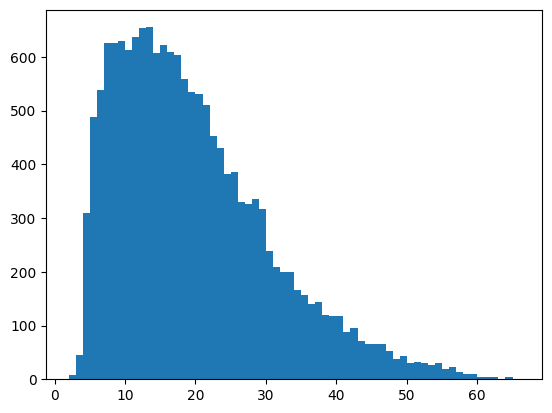

In [18]:
lengths = [len(t.split(' ')) for t in train_tweets]
plt.hist(lengths, bins=len(set(lengths)))
plt.show()

In [19]:
maxlen = 50
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [20]:
def get_sequences(tokenizer, tweets):
    sequences = tokenizer.texts_to_sequences(tweets)
    padded_sequences = pad_sequences(sequences, truncating='post', padding='post', maxlen=maxlen)
    return padded_sequences

In [21]:
padded_train_sequences = get_sequences(tokenizer, train_tweets)
padded_val_sequences = get_sequences(tokenizer, val_tweets)
padded_test_sequences = get_sequences(tokenizer, test_tweets)


In [22]:
padded_train_sequences[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

## Task 6: Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [23]:
classes = set(train_labels)
classes

{0, 1, 2, 3, 4, 5}

In [24]:
print(train_tweets[0],train_labels[0])

i didnt feel humiliated 0


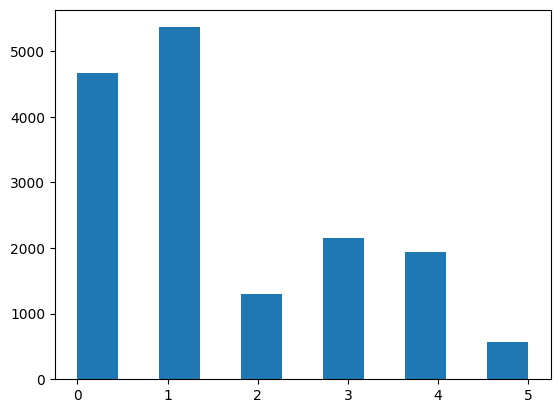

In [26]:
plt.hist(train_labels, bins=11)
plt.show()

In [27]:
classes_to_index = dict((c,i) for i,c in enumerate(classes))
index_to_classes = dict((v,k) for k,v in classes_to_index.items())

In [28]:
classes_to_index

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}

In [29]:
index_to_classes

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}

In [30]:
names_to_ids = lambda labels: np.array([classes_to_index.get(x) for x in labels])

In [31]:
train_labels = names_to_ids(train_labels)
val_labels = names_to_ids(val_labels)
test_labels = names_to_ids(test_labels)

In [32]:
print(train_labels[0])

0


## Task 7: Creating the Model

1. Creating the model
2. Compiling the model

In [36]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 16),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [37]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## Task 8: Training the Model

1. Preparing a validation set
2. Training the model

In [38]:
val_tweets, val_labels = get_tweets(val)
val_sequences = get_sequences(tokenizer, val_tweets)

In [39]:
val_lablels = names_to_ids(val_labels)

In [40]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 0)

In [41]:
h = model.fit(
    padded_train_sequences, train_labels,
    validation_data=(val_sequences, val_labels),
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/20
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3727 - loss: 1.5369

ValueError: Unrecognized data type: x=[[ 17   8 157 ...   0   0   0]
 [  2   3  14 ...   0   0   0]
 [  2   3  14 ...   0   0   0]
 ...
 [  2   3  79 ...   0   0   0]
 [  2 395   3 ...   0   0   0]
 [  2   3  14 ...   0   0   0]] (of type <class 'numpy.ndarray'>)

In [42]:
# ipython-input-39-e2e57103e139
val_labels = names_to_ids(val_labels) # Corrected the typo to val_labels

# ipython-input-41-e2e57103e139
h = model.fit(
    padded_train_sequences, train_labels,
    validation_data=(val_sequences, np.array(val_labels)), # Convert val_labels to a NumPy array
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.6994 - loss: 0.8202 - val_accuracy: 0.7450 - val_loss: 0.7104
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.8268 - loss: 0.4809 - val_accuracy: 0.8380 - val_loss: 0.4973
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9169 - loss: 0.2708 - val_accuracy: 0.8585 - val_loss: 0.4326
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9416 - loss: 0.1873 - val_accuracy: 0.8785 - val_loss: 0.3833
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9550 - loss: 0.1498 - val_accuracy: 0.8735 - val_loss: 0.3985
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9641 - loss: 0.1236 - val_accuracy: 0.8875 - val_loss: 0.3856
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.9720 - loss: 0.0920 - val_accuracy: 0.8870 - val_loss: 0.4025
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.9782 - loss: 0.0715 - val_

## Task 9: Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

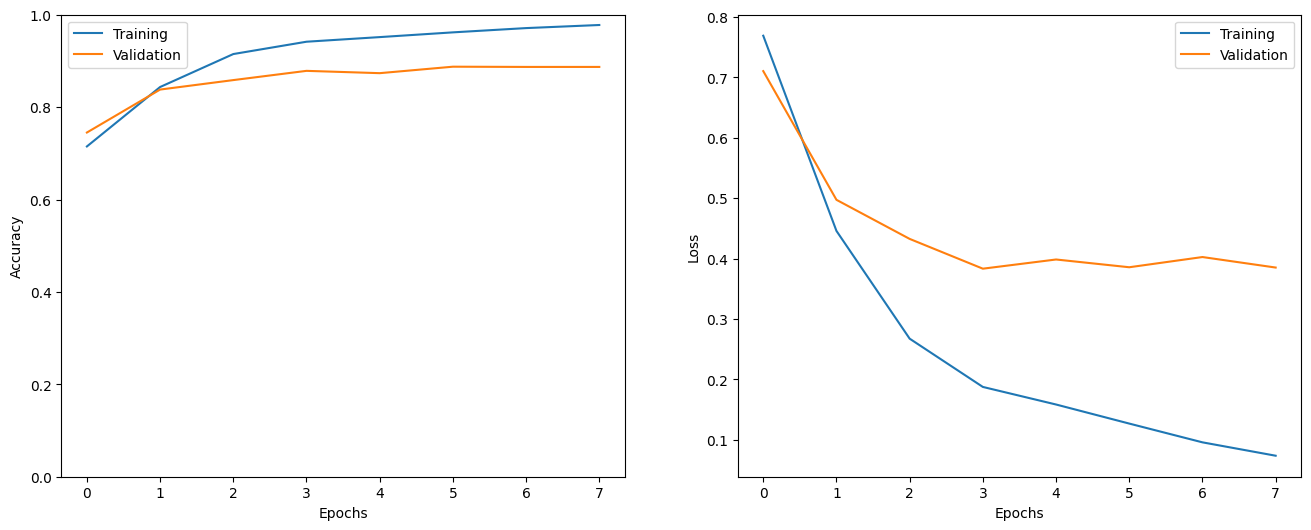

In [43]:
show_history(h)

In [44]:
test_tweets, test_labels = get_tweets(test)
test_sequences = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

In [45]:
_ = model.evaluate(test_sequences, test_labels)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8877 - loss: 0.3806


In [48]:
i = random.randint(0, len(test_labels)-1)
print('Sentence:', test_tweets[i])
print('Index Emotion:', index_to_classes[test_labels[i]])
'''{
              0: 'sadness'
              1: 'joy'
              2: 'love'
              3: 'anger'
              4: 'fear'
              5: 'surprise'
            }'''
# the above are the coreesponding values for the indexes
emotions = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
print('Emotion:', emotions[test_labels[i]])

p = model.predict_classes(np.expand_dims(test_sequences[i], axis=0))[0]
pred_class = index_to_classes[np.argmax(p).astype('uint8')]
print('Predicted Emotion:', emotions[index_to_classes[p]])

Sentence: i couldn t help but feel pissed off at both sides of the debate and the unnecessary dichotomy itself
Index Emotion: 3
Emotion: anger


AttributeError: 'Sequential' object has no attribute 'predict_classes'

In [61]:
i = random.randint(0, len(test_labels)-1)
print('Sentence:', test_tweets[i])
print('Index Emotion:', index_to_classes[test_labels[i]])
'''{
              0: 'sadness'
              1: 'joy'
              2: 'love'
              3: 'anger'
              4: 'fear'
              5: 'surprise'
            }'''
# the above are the coreesponding values for the indexes
emotions = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
print('Emotion:', emotions[test_labels[i]])

# Use `predict` and `np.argmax` for prediction
p = model.predict(np.expand_dims(test_sequences[i], axis=0))
pred_class = index_to_classes[np.argmax(p).astype('uint8')]
print('Predicted Emotion:', emotions[pred_class]) # Changed from emotions[index_to_classes[p]]

Sentence: i know is that she s here and i m so thankful for her warm loving and peaceful presence i feel when my anger or feelings of discontent and frustration flare up
Index Emotion: 0
Emotion: sadness
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted Emotion: joy


In [62]:
preds = model.predict_classes(test_sequences)
preds.shape, test_labels.shape

AttributeError: 'Sequential' object has no attribute 'predict_classes'

In [63]:
# Use `predict` and `np.argmax` for prediction
preds = np.argmax(model.predict(test_sequences), axis=-1)
preds.shape, test_labels.shape

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


((2000,), (2000,))

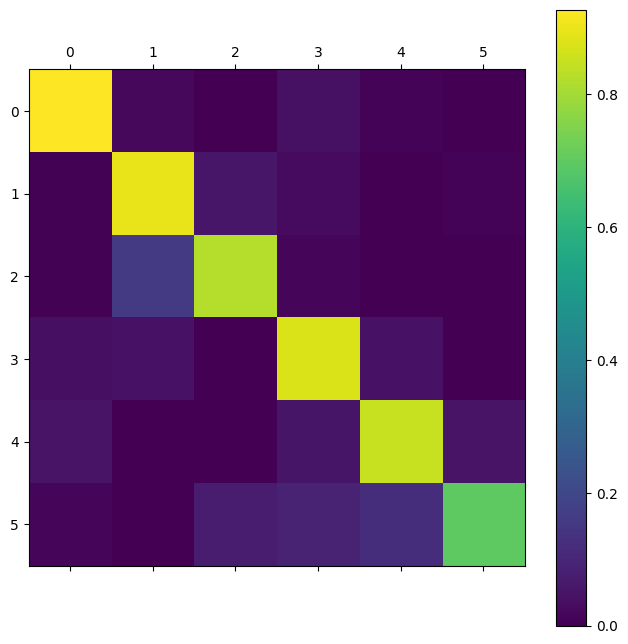

In [64]:
show_confusion_matrix(test_labels, preds, list(classes))